# Bitcoin Price Prediction

Use the "Run" button to execute the code.

## Import Libraries and Download Dataset

In [58]:
# Data wrangling
import pandas as pd
import numpy as np

# Data visualisation
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['figure.figsize'] = (10,5)
matplotlib.rcParams['figure.facecolor']='#00000000'
import matplotlib.pyplot as plt
%matplotlib inline

#Statistics
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Jovian/snehabajaj108 bitcoin-time-series-analysis/BTC-USD-2018.csv', parse_dates=['Date'])

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,14112.2002,14112.20020,13154.70020,13657.20020,13657.20020,10291200000
1,2018-01-02,13625.0000,15444.59961,13163.59961,14982.09961,14982.09961,16846600192
2,2018-01-03,14978.2002,15572.79981,14844.50000,15201.00000,15201.00000,16871900160
3,2018-01-04,15270.7002,15739.70020,14522.20020,15599.20020,15599.20020,21783199744
4,2018-01-05,15477.2002,17705.19922,15202.79981,17429.50000,17429.50000,23840899072


In [5]:
df.shape

(1586, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586 entries, 0 to 1585
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1586 non-null   datetime64[ns]
 1   Open       1586 non-null   float64       
 2   High       1586 non-null   float64       
 3   Low        1586 non-null   float64       
 4   Close      1586 non-null   float64       
 5   Adj Close  1586 non-null   float64       
 6   Volume     1586 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 86.9 KB


In [7]:
df.set_index('Date', drop=True, inplace=True)

In [8]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1.586000e+03
mean,20163.358290,20678.770140,19589.589725,20176.659494,20176.659494,2.587217e+10
std,18141.895457,18617.466038,17596.485331,18142.839312,18142.839312,2.046941e+10
min,3236.274658,3275.377930,3191.303467,3236.761719,3236.761719,2.923670e+09
25%,7294.870362,7438.794800,7165.319580,7293.890747,7293.890747,9.345378e+09
50%,9866.986328,10136.996095,9655.319336,9867.606934,9867.606934,2.290166e+10
75%,37317.280278,38629.461913,35833.551757,37334.012698,37334.012698,3.545896e+10
max,67549.734380,68789.625000,66382.062500,67566.828130,67566.828130,3.509679e+11


In [9]:
#Closing Price df

price_df = df['Close']
price_df = pd.DataFrame(price_df).rename(columns={'Close':'Price'})
price_df.head()

,Price
Date,
2018-01-01,13657.20020
2018-01-02,14982.09961
2018-01-03,15201.00000
2018-01-04,15599.20020
2018-01-05,17429.50000


In [10]:
price_df.index = pd.to_datetime(price_df.index)

## Understanding Time Series

<Axes: title={'center': 'Bitcoin Closing Price (USD)'}, xlabel='Year', ylabel='Price'>

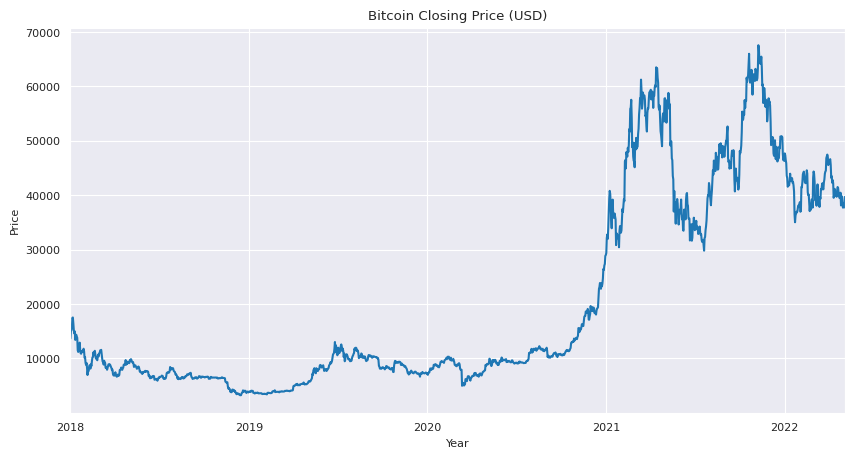

In [11]:
price_df.plot(legend=False, xlabel='Year', ylabel='Price',
              title = 'Bitcoin Closing Price (USD)')

There is no consistent increasing/decreasing trend. There is a sharp rise in price during the 1st & 3rd quarter of 2021.

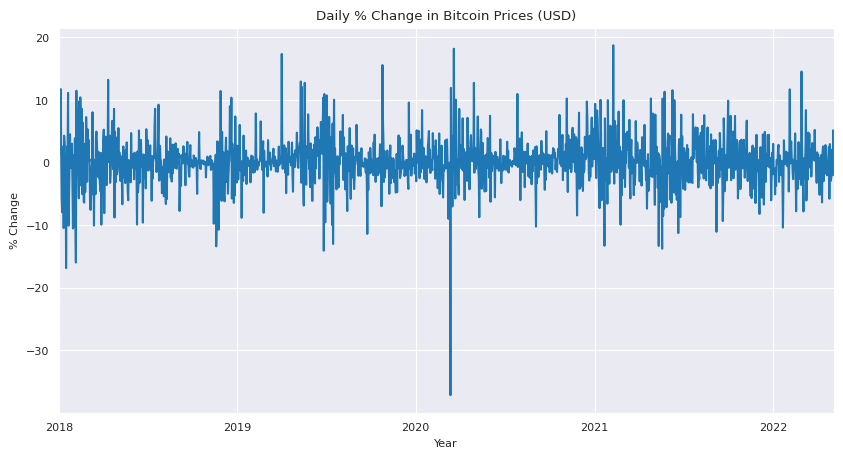

In [12]:
# Percentage change
price_df.Price.pct_change().mul(100).plot(figsize=(10,5))
plt.ylabel('% Change')
plt.xlabel('Year')
plt.title('Daily % Change in Bitcoin Prices (USD)')
plt.show();

The % change in daily prices ranges from -10% to 10% except for a few outliers

### Resampling

1. **Upsampling:** Time series is resampled from low frequency to high frequency (Eg: Monthly to daily frequency). It involves filling or interpolating missing data

2. **Downsampling:** Time series is resampled from high frequency to low frequency (Eg: Weekly to monthly frequency). It involves aggregation of existing data.

We shall use the `resample()` method to plot the maximum yearly/quarterly/monthly/weekly prices

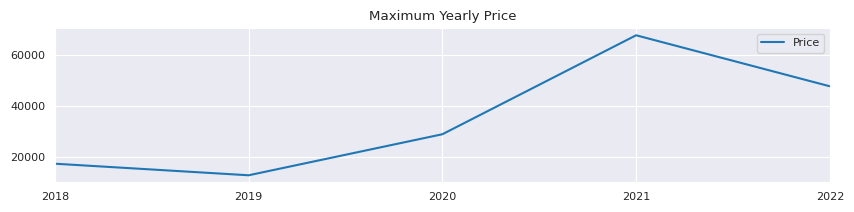

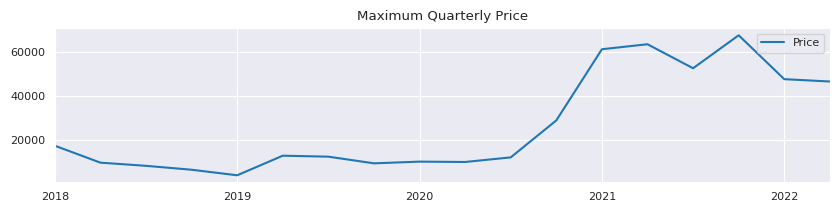

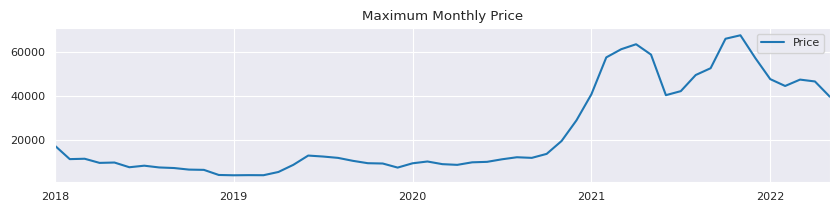

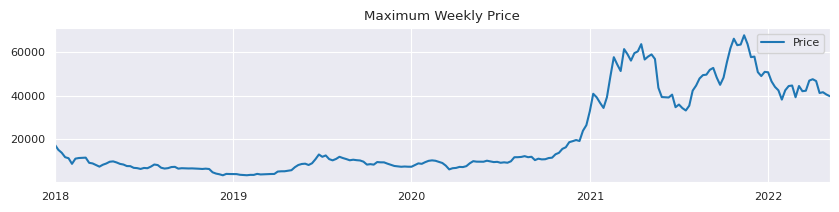

In [13]:
matplotlib.rcParams.update({'figure.figsize': (10,2)})
freq = ['Yearly', 'Quarterly', 'Monthly', 'Weekly']
for i in freq:
  price_df.resample(f'{i[0]}').max().plot()
  plt.title(f'Maximum {i} Price')
  plt.xlabel('')
plt.show()

### Decomposition

The `seasonal_decompose` function is a method available in the `statsmodels.tsa.seasonal` module. It is used to decompose a time series into its constituent components:
1. Trend: the general direction of the series over a long period of time
2. Seasonality: a repititive pattern observed in regular intervals due to seasonal factors (monthly/weekly/quarterly)
3. Residuals: The irregular component explaining the fluctuations in the time series after removing the other components

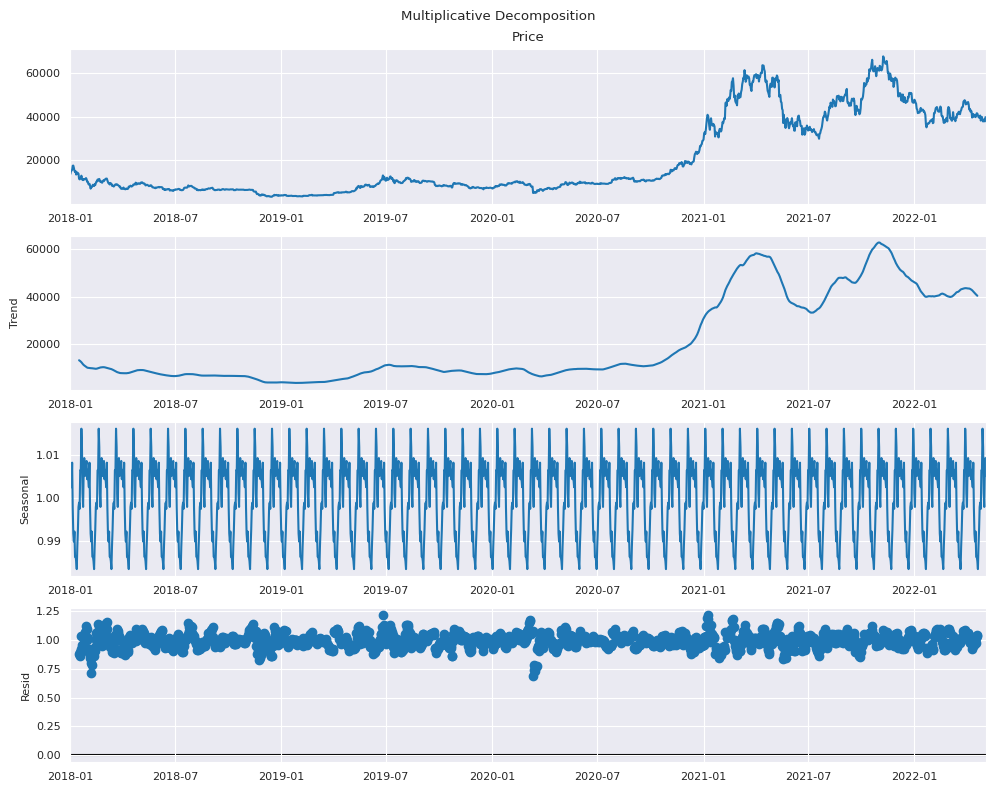

In [14]:
# Multiplicative Decomposition

multiplicative = seasonal_decompose(price_df['Price'], model='multiplicative', period = 30)
matplotlib.rcParams.update({'figure.figsize': (10,8)})
multiplicative.plot().suptitle('Multiplicative Decomposition')
plt.tight_layout()
plt.show()

In multiplicative decomposition, the original time series is expressed as the product of the trend, seasonality, and residual components. Mathematically, it can be represented as:  
Y(t) = Trend(t) * Seasonality(t) * Residual(t)

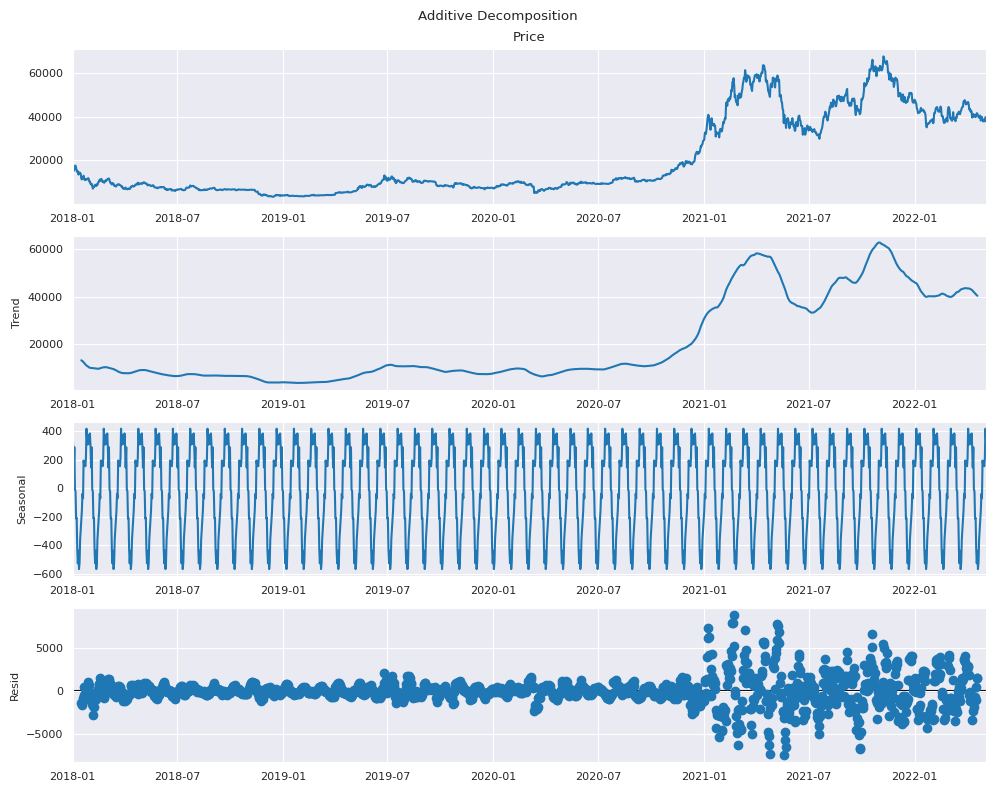

In [15]:
# Additive Decomposition

multiplicative = seasonal_decompose(price_df['Price'], model='additive', period = 30)
multiplicative.plot().suptitle('Additive Decomposition')
plt.tight_layout()
plt.show()

In additive decomposition, the original time series is expressed as the sum of the trend, seasonality, and residual components. Mathematically, it can be represented as:  
Y(t) = Trend(t) + Seasonality(t) + Residual(t)

### Stationarity

Many models for time series analysis assume stationarity of the input time series data. **A time series is stationary when its mean, variance and covariance are not a function of time.**
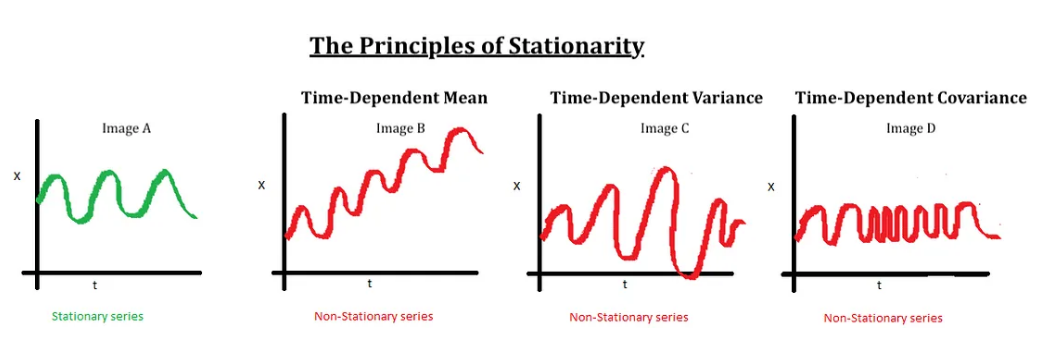


**An illustration of the principles of stationarity, Source: BeingDatum**

To find out if our time series is stationary, we can check if the rolling mean and standard deviation of the time series is consistent.

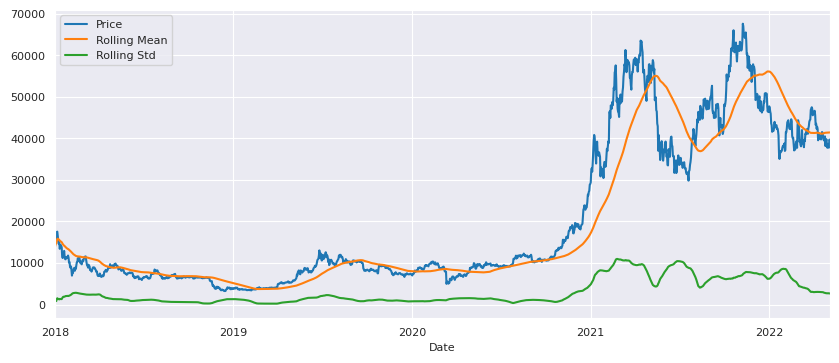

In [16]:
rolling_mean = price_df.Price.rolling('90D').mean()
rolling_std = price_df.Price.rolling('90D').std()
matplotlib.rcParams.update({'figure.figsize':(10,4)})
price_df.plot()
rolling_mean.plot()
rolling_std.plot()
plt.legend(['Price','Rolling Mean', 'Rolling Std'])
plt.show();

Since the rolling mean and standard deviation is varying a lot over time, we can conclude that the time series is not stationary

A popular statistical method to test for stationarity of time series is the **Augmented Dickey Fuller test** or (ADF Test)

The ADF test examines:  
* **Null hypothesis**: The time series is not stationary (has a unit root)
* **Alternative hypothesis**: The time series is stationary.
The test computes a test statistic, along with p-value.  
If the p-value is less than 0.05, we can reject the null hypothesis and conclude that the time series is stationary. Else, we use different methods (transformation or differencing) to make the time series stationary.

In [17]:
adf = adfuller(price_df.Price)
print(f'Test Statistic: {adf[0]: .3f}')
print(f'P-value: {adf[1]: .3f}')

Test Statistic: -0.975
P-value:  0.762


Since the p value is much higher than 0.05, we can conclude that the time series is not stationery

### Differencing

Differencing a time series is a technique used to remove the trend or other non-stationary components from the data. It involves calculating the differences between consecutive observations to transform the data into a stationary series.

1. First Order Differencing:
> * First order differencing involves subtracting each observation from its previous observation.
> * This can be done using the .diff() method in pandas or by manually subtracting the previous value from the current value.
> * First order differencing is effective for removing linear trends or removing simple seasonality with a fixed period.

2. Seasonal Differencing:
> * Seasonal differencing involves subtracting observations from the same season in the previous year or period.
> * This is useful for removing seasonality with a longer period, such as quarterly or yearly patterns.
> * Seasonal differencing can be combined with first order differencing if the series exhibits both trends and seasonality.

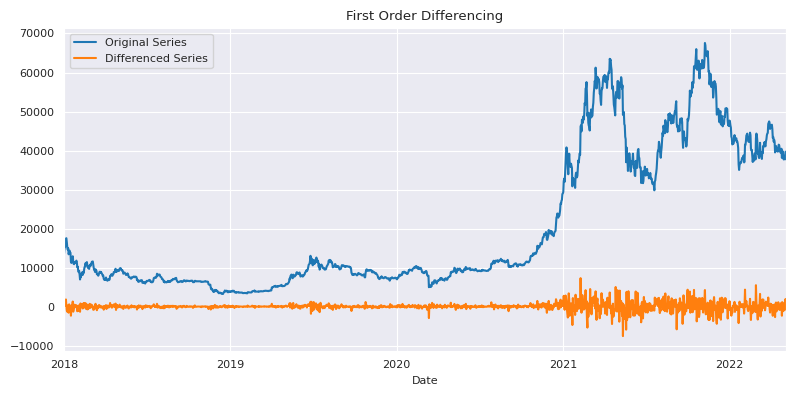

In [18]:
matplotlib.rcParams.update({'figure.figsize':(8,4)})

# Original Time Series
price_df.plot()

# 1st Differencing
price_df.Price.diff().dropna().plot()
plt.title('First Order Differencing')
plt.legend(['Original Series','Differenced Series'])

plt.tight_layout()
plt.show();

In [19]:
# AdFuller after differencing

adf = adfuller(price_df.Price.diff().dropna())
print(f'Test Statistic: {adf[0]: .3f}')
print(f'P-value: {adf[1]: .3f}')

Test Statistic: -7.766
P-value:  0.000


We can see that the time series reaches stationarity with **ONE** order of differencing

## Model Evaluation Metrics

In [88]:
#Function to Evaluate Model

def model_evaluation(y_actual, y_forecast):
  MAE = mean_absolute_error(y_true=y_actual, y_pred=y_forecast)
  RMSE = mean_squared_error(y_true=y_actual, y_pred=y_forecast, squared=False)
  MAPE = np.mean(np.abs((y_actual-y_forecast)/y_actual))*100
  corr = np.corrcoef(y_actual, y_forecast)[0,1]
  return print(f"MAE: {MAE}\nRMSE: {RMSE}\nMAPE: {MAPE}\nCorrelation: {corr}")

In [21]:
train_df = price_df.loc[:'2021-12-31']
test_df = price_df.loc['2022-01-01':]

In [22]:
print("train_df shape: ", train_df.shape)
print("test_df shape: ", test_df.shape)

train_df shape:  (1461, 1)
test_df shape:  (125, 1)


## ARIMA

ARIMA (Autoregressive Integrated Moving Average) is a popular time series forecasting model that combines the following components to capture the underlying patterns and relationships in the data:  
1. autoregressive (AR): In an autoregressive model of order p, denoted as AR(p), the value of the variable at time t is expressed as a linear combination of the p previous values of the same variable, along with a random error term.
2. differencing (I)
3. moving average (MA): In an MA model of order q, denoted as MA(q), the value of the variable at time t is a function of the q previous error terms/residuals, along with a random error term.

The general notation for an ARIMA model is ARIMA(p, d, q), where:
* **p** represents the order of the autoregressive (AR) component, indicating the number of lagged values used in the model.
* **d** represents the degree of differencing, indicating the number of times differencing is performed to achieve stationarity.
* **q** represents the order of the moving average (MA) component, indicating the number of lagged forecast errors used in the model.

Based on the following guidelines, you can determine the values of p and q:  

**AR Term (p)**: Look at the PACF plot and identify the lag(s) where there is a significant spike or bar that extends beyond the confidence bounds. The number of significant spikes or bars in the PACF plot beyond the confidence bounds suggests the potential value of p.  
**MA Term (q)**: Look at the ACF plot and identify the lag(s) where there is a significant spike or bar that extends beyond the confidence bounds. The number of significant spikes or bars in the ACF plot beyond the confidence bounds suggests the potential value of q.

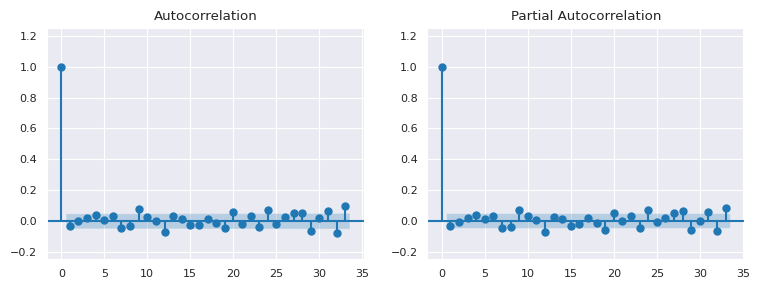

In [20]:
# ACF & PACF plot of 1st differenced series
matplotlib.rcParams.update({'figure.figsize':(9,3)})
fig, axes = plt.subplots(1,2)
plot_acf(price_df.Price.diff().dropna(), ax=axes[0])
axes[0].set(ylim=(-0.25,1.25))
plot_pacf(price_df.Price.diff().dropna(), ax = axes[1])
axes[1].set(ylim=(-0.25,1.25))
plt.show();

We can try ARIMA with the values p=1, d=1 and q=1.

Let's split the data into train and test dataset inorder to apply ARIMA

In [89]:
# Function to plot forecast vs Actual

def f_plot(model):
  # Output of ARIMA forecast: forecast, standard errors, confidence intervals
  forecast = model_fit.get_forecast(steps=125, alpha=0.05)
  f = forecast.predicted_mean
  ci = forecast.conf_int()

  #Prapare Pandas Series
  forecast_series = pd.Series(f, index=test_df.index)
  lower_limit = pd.Series(ci.iloc[:,0], index = test_df.index)
  upper_limit = pd.Series(ci.iloc[:,1], index = test_df.index)

  result = model_evaluation(test_df['Price'], forecast_series)

  #Plot actual and forecast values
  plt.figure(figsize=(8,4))
  plt.plot(train_df)
  plt.plot(test_df)
  plt.plot(forecast_series)
  plt.fill_between(lower_limit.index, lower_limit, upper_limit, color='k', alpha=0.15)
  plt.legend(['Train Data', 'Actual', 'Forecast'])
  plt.title('ARIMA Forecast v/s Actual')
  plt.show()
  return result

MAE: 5198.904482728785
RMSE: 5862.8814883974765
MAPE: 13.125013870171879
Correlation: 0.16634262562195432


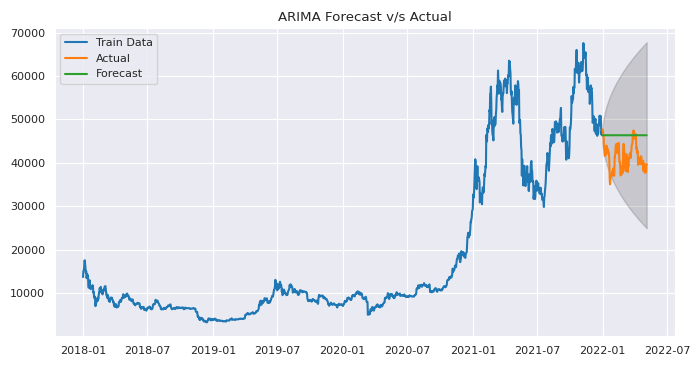

In [90]:
# Predicting 125 timesteps based on fixed training data

model = ARIMA(train_df, order=(1,1,1))
model_fit = model.fit()

f_plot(model)

MAE: 2741.740475498989
RMSE: 3330.685697055857
MAPE: 6.472636826170172
Correlation: -0.06160865676042431


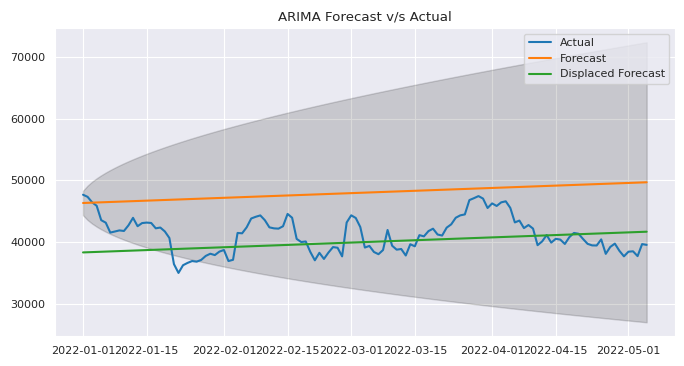

In [91]:
# Displaced Forecast
displaced_forecast = forecast_series-8000

model_evaluation(test_df['Price'], displaced_forecast)

plt.figure(figsize=(8,4))
plt.plot(test_df)
plt.plot(forecast_series)
plt.plot(displaced_forecast)
plt.fill_between(lower_limit.index, lower_limit, upper_limit, color='k', alpha=0.15)
plt.legend(['Actual', 'Forecast', 'Displaced Forecast'])
plt.title('ARIMA Forecast v/s Actual')
plt.show();

MAE: 5175.382653440002
RMSE: 5838.955202611527
MAPE: 13.066450107082241
Correlation: nan


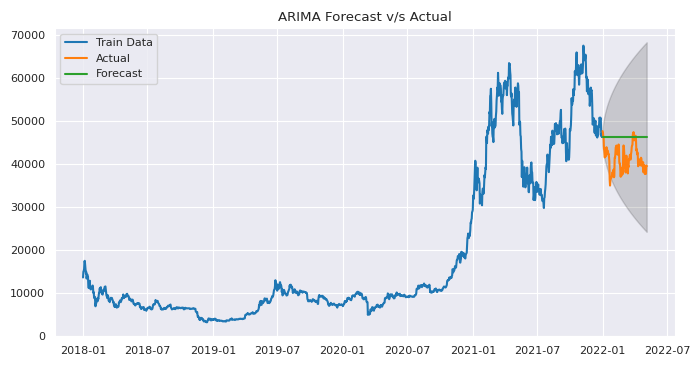

In [95]:
# Predicting 125 timesteps based on fixed training data

model = ARIMA(train_df, order=(0,1,0))
model_fit = model.fit()

f_plot(model)

MAE: 2703.704678355996
RMSE: 3111.353136783477
MAPE: 6.518875374873008
Correlation: -0.06160865676042431


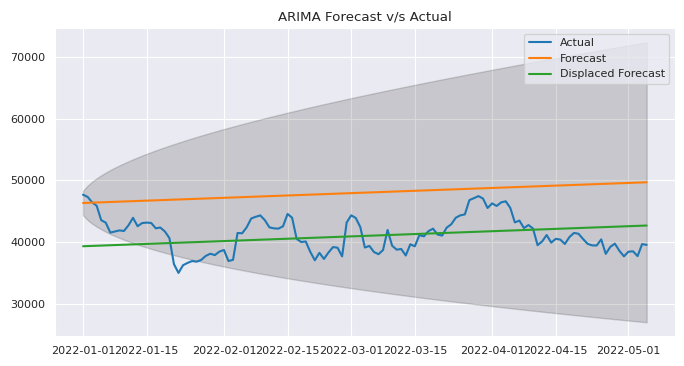

In [99]:
# Displaced Forecast
displaced_forecast = forecast_series-7000

model_evaluation(test_df['Price'], displaced_forecast)

plt.figure(figsize=(8,4))
plt.plot(test_df)
plt.plot(forecast_series)
plt.plot(displaced_forecast)
plt.fill_between(lower_limit.index, lower_limit, upper_limit, color='k', alpha=0.15)
plt.legend(['Actual', 'Forecast', 'Displaced Forecast'])
plt.title('ARIMA Forecast v/s Actual')
plt.show();

## Rolling Prediction

This prediction was made for 125 timesteps at once based on a fixed set of training data. We will now use a different approach where the prediction for each timestep will be made successively on the basis of expanding training data

In [25]:
# Predicting 125 timesteps basis expanding training data

model_predictions=[]
training_data = list(train_df.Price)
testing_data = list(test_df.Price)

for i in range(len(testing_data)):
  model = ARIMA(training_data, order = (0,1,0))
  model_fit = model.fit()
  output = model_fit.forecast(1)
  y = output[0]
  model_predictions.append(y)
  actual_test_value = testing_data[i]
  training_data.append(actual_test_value)

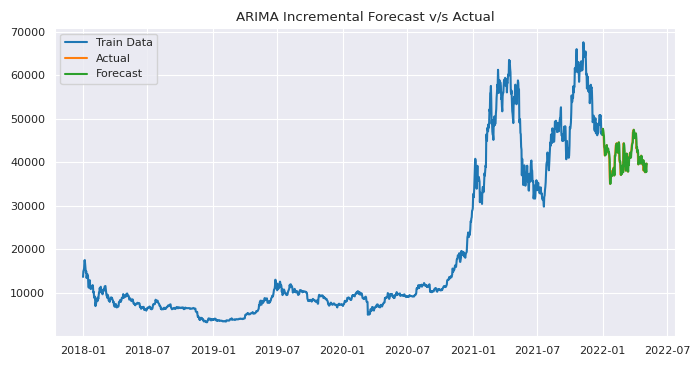

In [26]:
#Prapare Pandas Series
model_predictions = pd.Series(model_predictions, index=test_df.index)

#Plot actual and forecast values
plt.figure(figsize=(8,4))
plt.plot(train_df)
plt.plot(test_df)
plt.plot(model_predictions)
plt.legend(['Train Data', 'Actual', 'Forecast'])
plt.title('ARIMA Incremental Forecast v/s Actual')
plt.show();

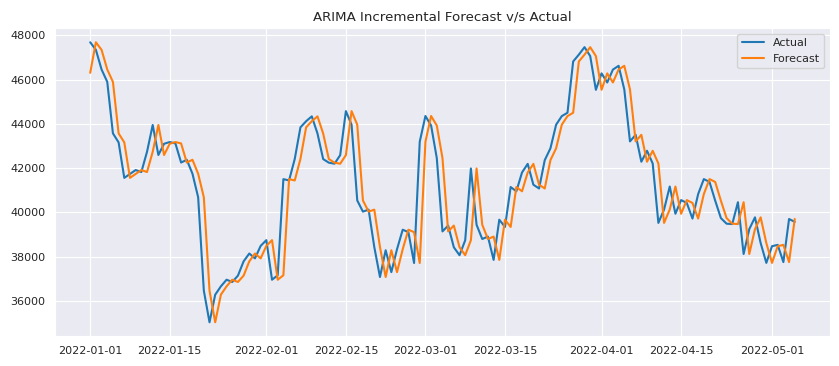

In [27]:
# Closer look
#Plot actual and forecast values
plt.figure(figsize=(10,4))
plt.plot(test_df)
plt.plot(model_predictions)
plt.legend(['Actual', 'Forecast'])
plt.title('ARIMA Incremental Forecast v/s Actual')
plt.show();

## Prophet

In [109]:
# Format data for prophet model using ds and y

train_df_p = train_df.reset_index().rename(columns={'Date':'ds',
                                                    'Price':'y'})
train_df_p.head()

,ds,y
0,2018-01-01,13657.20020
1,2018-01-02,14982.09961
2,2018-01-03,15201.00000
3,2018-01-04,15599.20020
4,2018-01-05,17429.50000


In [125]:
model = Prophet()
model.fit(train_df_p)
future_dates = model.make_future_dataframe(periods=125)
f = model.predict(future_dates)
f.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq2tic0kn/7uugd3qj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq2tic0kn/uoh9zo05.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75844', 'data', 'file=/tmp/tmpq2tic0kn/7uugd3qj.json', 'init=/tmp/tmpq2tic0kn/uoh9zo05.json', 'output', 'file=/tmp/tmpq2tic0kn/prophet_modelusar6swz/prophet_model-20230719183244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,9624.556833,5122.305263,16248.416741,9624.556833,9624.556833,777.775743,777.775743,777.775743,32.308225,32.308225,32.308225,745.467517,745.467517,745.467517,0.0,0.0,0.0,10402.332576
1,2018-01-02,9613.032339,5296.679789,16238.874277,9613.032339,9613.032339,1005.506300,1005.506300,1005.506300,-47.942174,-47.942174,-47.942174,1053.448474,1053.448474,1053.448474,0.0,0.0,0.0,10618.538638
2,2018-01-03,9601.507844,5549.311758,16051.725715,9601.507844,9601.507844,1346.288675,1346.288675,1346.288675,10.372609,10.372609,10.372609,1335.916065,1335.916065,1335.916065,0.0,0.0,0.0,10947.796519
3,2018-01-04,9589.983350,5956.311108,16291.656331,9589.983350,9589.983350,1525.551458,1525.551458,1525.551458,-63.298294,-63.298294,-63.298294,1588.849752,1588.849752,1588.849752,0.0,0.0,0.0,11115.534808
4,2018-01-05,9578.458855,5976.148351,16827.603955,9578.458855,9578.458855,1802.756533,1802.756533,1802.756533,-6.063520,-6.063520,-6.063520,1808.820053,1808.820053,1808.820053,0.0,0.0,0.0,11381.215388


In [126]:
model.component_modes

{'additive': ['yearly',
  'weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

MAE: 15536.932847450964
RMSE: 15861.218585871484
MAPE: nan
Correlation: 0.07220767674727642


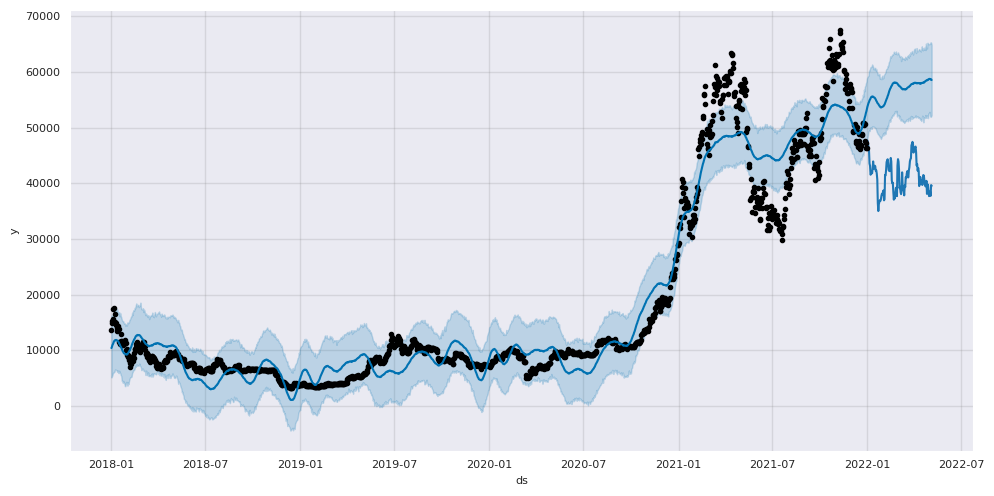

In [134]:
#model evaluation
model_evaluation(test_df['Price'], f['yhat'].tail(125))

fig, ax = plt.subplots(1)
ax.plot(test_df)
model.plot(f, ax=ax)
plt.show();

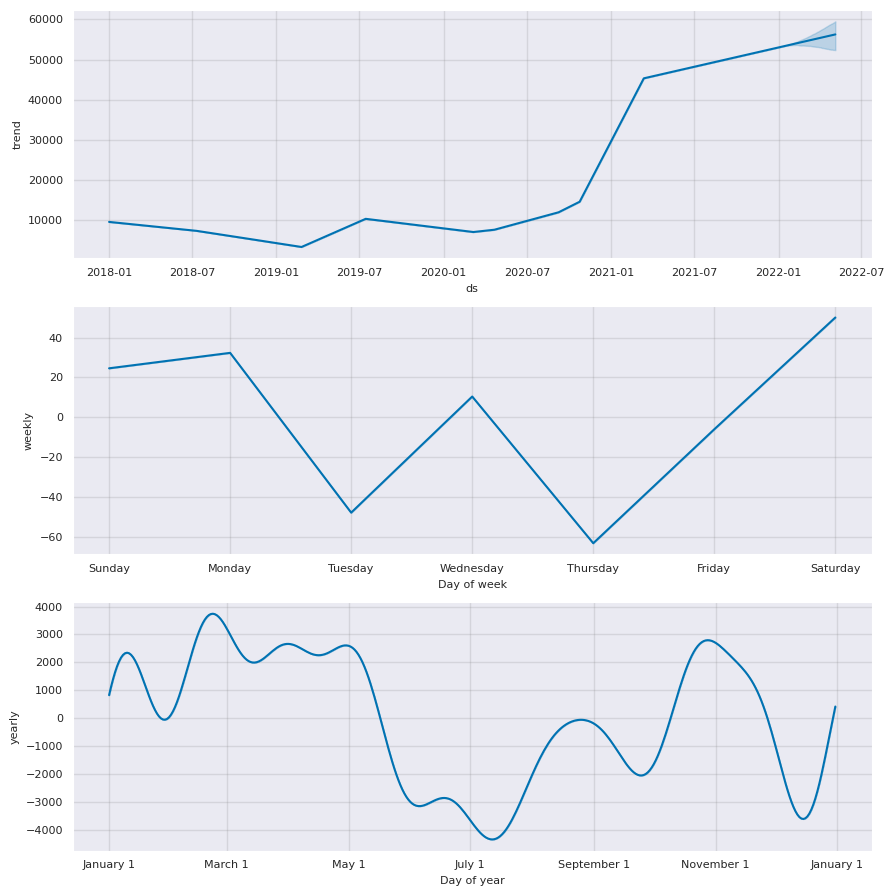

In [138]:
fig2 = model.plot_components(f)

## LSTM